<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from operator import itemgetter
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

sns.set(style="darkgrid")

In [2]:
pd.set_option('display.max_rows', 200)

In [3]:
try:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    print('Что то пошло не так!')

<b>train - тренировочная выборка   
test - проверочная выборка  
df - полная выборка

Хранилка-словарь с нашими данными:

In [4]:
datas = {'обучающая выборка': train,
        'тестовая выборка': test,
        'полная выборка': df}

In [5]:
# глянем на размеры выборок
for k, v in datas.items():
    print(f'{k}, размер: {v.shape}')


обучающая выборка, размер: (14149, 87)
тестовая выборка, размер: (5290, 53)
полная выборка, размер: (19439, 87)


В принципе, можно бы было использовать самостоятельно разделение данных, примерно 4/1, было бы меньше манипуляций. Но ТЗ.

Функция, которая будет искать недостающие колонки:

In [6]:
def get_col_diff(df1, df2):
    return set(df1.columns) - (set(df2.columns))

In [7]:
get_col_diff(train, test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовом наборе не хватает 33-х столбцов.

Как было указано в ТЗ, в тестовой выборке недоступны признаки, которые нельзя рассчитать до момента запуска процесса очистки. Что вполне логично. Тут находятся характеристики процесса на промежуточных и финальной стадиях. То есть, эти признаки будут недоступны и для работы модели, которая должна строить прогнозы исходя из "вводных" данных.

In [8]:
get_col_diff(df, test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [9]:
# Функция, которая будет искать с сортировкой столбцы с недостающими данными:
def get_na_cols(df, n=10):
    return df.isna().sum().sort_values(ascending=False).head(n)

In [10]:
# функция для поиска колонок по фрагменту имени:
def search_cols_name(df, text:str, opt_text='')->list:
    cols = []

    for col in df.columns:
        if text in col and opt_text in col:
            cols.append(col)

    return sorted(cols)   

In [11]:
search_cols_name(train, 'au') # запустим чтобы скопипастить для описания формулы

['final.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_au']

In [12]:
# обозначаем переменные и задаем формулу
F = train['rougher.input.feed_au']
C = train['rougher.output.concentrate_au']
T = train['rougher.output.tail_au']

R = C*(F-T) / (F*(C-T)) * 100 # Recovery
R_mae = mean_absolute_error(R, train['rougher.output.recovery'])
R_mae

9.73512347450521e-15

In [13]:
def rmae(df):
    F = df['rougher.input.feed_au']
    C = df['rougher.output.concentrate_au']
    T = df['rougher.output.tail_au']
    R = C*(F-T) / (F*(C-T)) * 100 # Recovery
    return mean_absolute_error(R, df['rougher.output.recovery'])

    

In [14]:
rmae(train)

9.73512347450521e-15

---

In [15]:
train['rougher.output.recovery'].describe()

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [16]:
R.describe()

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64

Вывод: ошибку mae можно считать ничтожно малой. Данные практически идентичны.

## Анализ данных

Обработаем названия столбцов. Это чтобы в дальнейшем свести данные в один график. Изменим значения столбцов rougher.input.feed_... на rougher.input.concentrate_... для металлов.

In [17]:
search_cols_name(df, 'concentrate_', )

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol']

In [18]:
search_cols_name(df, 'rougher.input.feed_' ) # вот это именование портит всю картину

['rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol']

In [19]:
def rename_to_conc(df): # напишем транслятор имени
    from_ = ['rougher.input.feed_ag', 'rougher.input.feed_au', 'rougher.input.feed_pb']
    to = ['rougher.input.concentrate_ag', 'rougher.input.concentrate_au', 'rougher.input.concentrate_pb']
    df.rename(columns={k: v for k, v in zip(from_, to)}, inplace=True)
    #return df

In [20]:
get_col_diff(df, test)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [21]:
rename_to_conc(df)

In [22]:
stages = ['rougher.input', 'rougher.output', 'primary_cleaner.output', 'final.output'] # стадии очистки
conc_metalls = ['concentrate_ag', 'concentrate_au', 'concentrate_pb'] # концентрации металлов

In [23]:
def make_vis_via_stages(df, is_sum=0): # визуализации концетрации металлов на стадиях очистки
    for conc_metall in conc_metalls:
        plt.figure(figsize=(15, 5))
        data = df[search_cols_name(df, conc_metall)]
        order = [stage+'.'+conc_metall for stage in stages]
        sns.violinplot(data=data, order=order)
        #sns.histplot(data=data)
        plt.show()
        

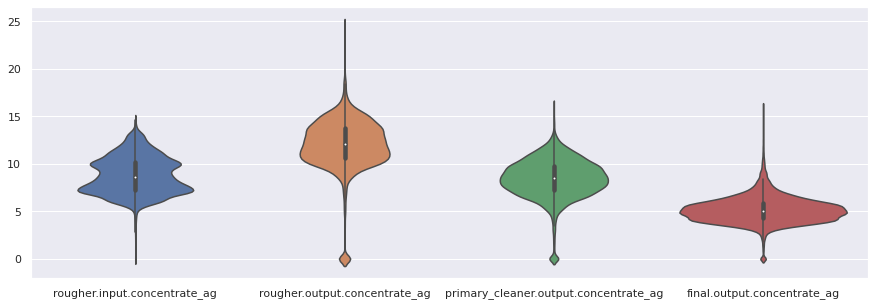

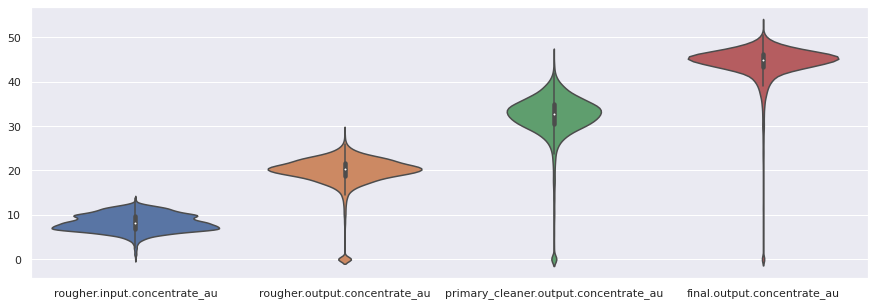

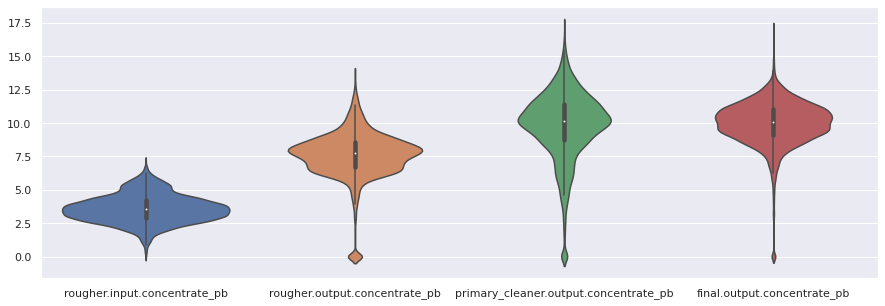

In [24]:
make_vis_via_stages(df)

Выводы: концентрация золота повышается от стадии к стадии. Концентрация серебра на выходе меньше исходной, а вот свинец медианно - увеличивается. В исходном сырье видно две моды концентраций, вероятно сырье было использовано двух разных типов (разных карьеров, например).  
Что самое неприятное, появляются хвосты, в том числе нулевые концентрации, которые можно считать выбросами, так как в исходном сырье не просматриваются нулевые концентрации. Вероятно, это вызвано погрешностью измерительной техники.

Посмотрим на распределение размеров гранул сырья в train и test

In [25]:
search_cols_name(train, 'size') #найдем нужный столбец

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

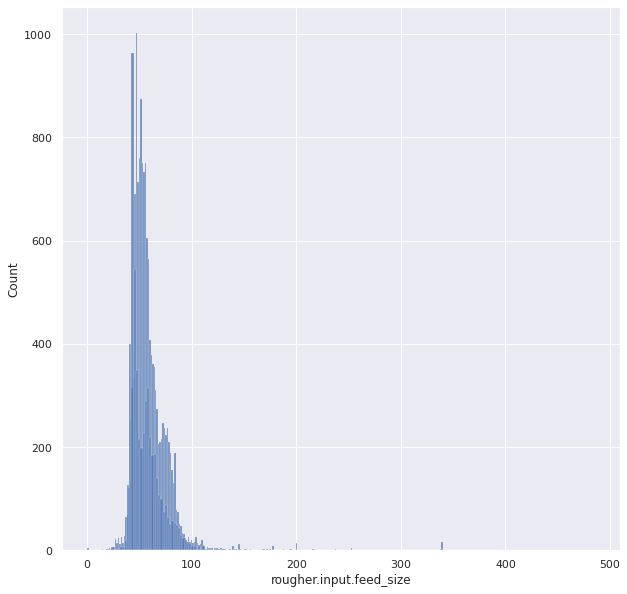

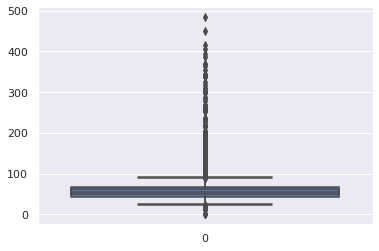

In [26]:
plt.figure(figsize=(10, 10))
sns.histplot(train['rougher.input.feed_size'])
sns.histplot(test['rougher.input.feed_size'])
plt.show()
sns.color_palette("rocket", as_cmap=True)
sns.boxplot(data=train['rougher.input.feed_size'])
sns.boxplot(data=test['rougher.input.feed_size'])
plt.show()

<div class="alert alert-block alert-info">
<h4> Комментарий студента: <a class="tocSkip"></h4>
Обновил немного текст и графики.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Распределения скошены вправо, видно, что ящики и усы боксплотов по сути легли друг на друга, гистограммы тоже схожи друг с другом с учетом различия масштабов выборок, что является признаком схожести выборок. Вывод: выборки можно считать корректными.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Правильно, распределения примерно одинаковы. Можно было тут еще добавить пару слов, на что похожи распределения, смещены ли...

---

Посмотрим на суммарное распределение концентреций метталов.ь

In [27]:
def make_vis_via_stages_all_met(df):
    df_cols = df.columns
    
    for stage in stages:
        cols = []
        for conc_metall in conc_metalls:
            cols+=search_cols_name(df, stage, conc_metall)
        
        data = df[cols].sum(axis=1)
        print('Стадия:', stage, ':')
        sns.histplot(data=data)
        plt.show()
    

Стадия: rougher.input :


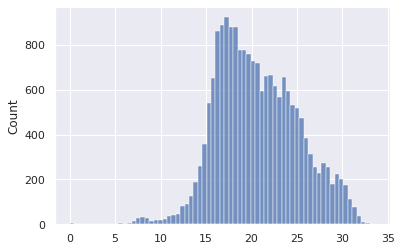

Стадия: rougher.output :


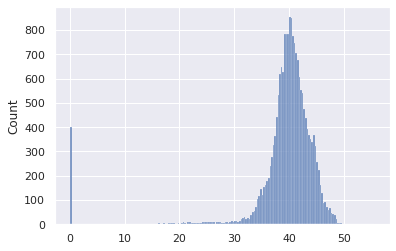

Стадия: primary_cleaner.output :


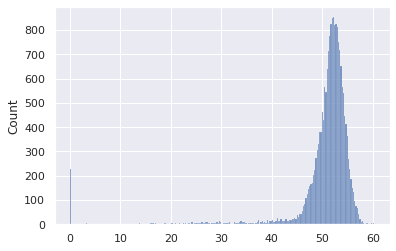

Стадия: final.output :


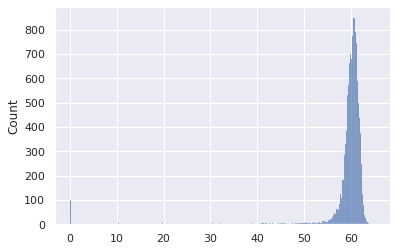

In [28]:
make_vis_via_stages_all_met(df)

Вывод: после каждой стадии очистки, разброс в распределении сокращается. Также снова видим хвост с выбросом в нуле.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Замечательно, суммарную концентрацию всех веществ на разных стадиях исследовали и нашли аномалии.
 
В целом отдельно по каждому веществу ноль может быть (не всегда же есть крупинки золота в руде), а ноль суммарно - вряд ли (в руде хоть что-то но будет). А если мы имеем ноль, значит большая вероятность неточности в измерениях.

Посмотрим на дубликаты.

In [29]:
train.duplicated().sum()

0

In [30]:
test.duplicated().sum()

0

Посмотрим на пропуски.

In [31]:
get_na_cols(train)

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
final.output.tail_pb                         100
dtype: int64

<div class="alert alert-block alert-info">
<h4> Комментарий студента: <a class="tocSkip"></h4>
Ниже подправлю логику заполнения пропусков. Хотя на результате эти улучшатели почти не отразились.
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Посмотрим на первые шесть по количеству пропусков колонок:

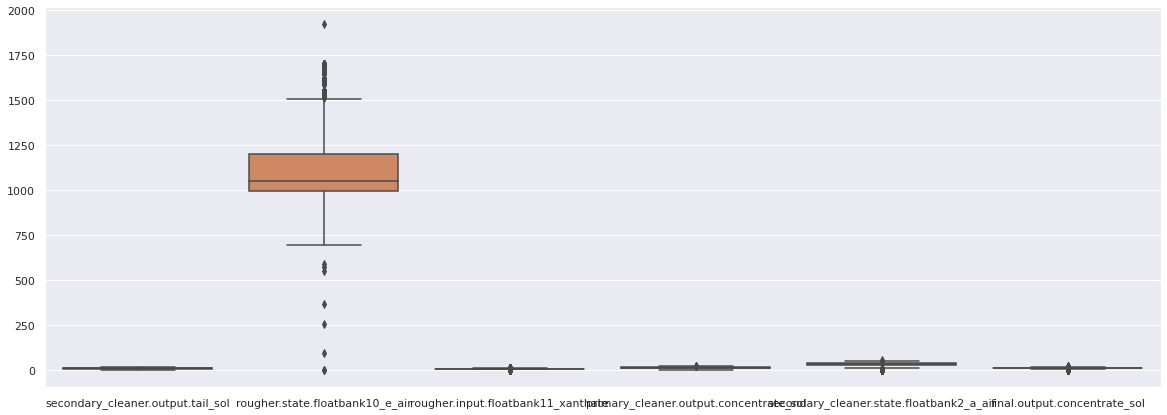

In [32]:
seven_na_cols = get_na_cols(train, 6).index
plt.figure(figsize=(20, 7))
sns.boxplot(data=(train[seven_na_cols]))
plt.show()

Наибольший размах по значениям, который потенциально может привести к ошибкам - rougher.state.floatbank10_e_air

Сложно сказать, не зная специфику производства, насколько важны отображаемые признаки. Будем считать, что если бы они были очень важными, то пропусков было бы значительно меньше. Удилим перые 2 столбца с макс. кол-вом пропусков, чтобы не нарушать разницу фич в трейне и тесте.

In [33]:
# to_drop = list(get_na_cols(train, 2).index)
# train = train.drop(columns=to_drop)

In [34]:
# print(train.shape)
# print(train.dropna().shape)

In [35]:
print(test.shape)
print(test.dropna().shape)

(5290, 53)
(5229, 53)


In [36]:
#sns.heatmap(train[get_na_cols(train)[:5]].corr())

<!-- Потеря при удалении строк с пропущенными значениями незначительны, данных, предополжительно, достаточно для обучения и проверки. Выполняем удаление. -->

In [37]:
# train = train.dropna()
# test = test.dropna()

train_test = train.interpolate() # вот тут не совсем понял, что за параметр order и правильно ли я его применил

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

order - степень полинома, которым интерполируют. order опускается, если используется линейный метод (как в твоем случае).

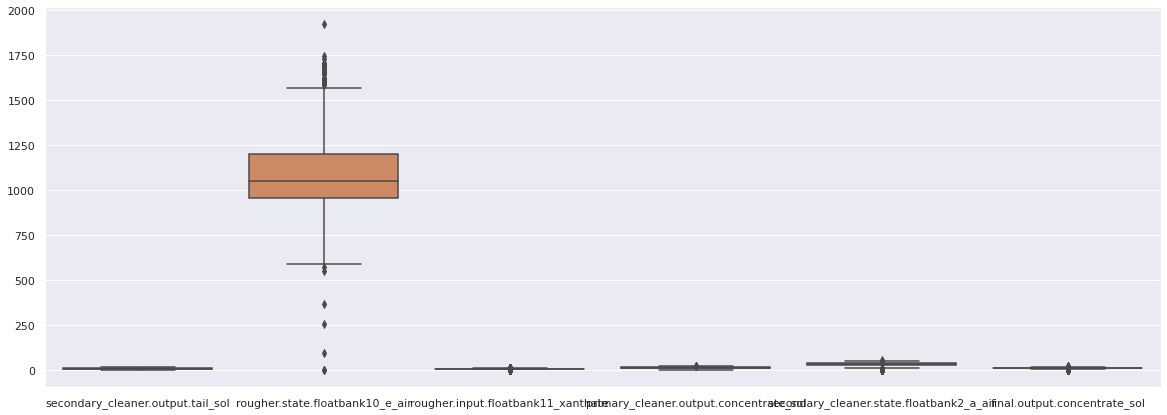

In [38]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=(train_test[get_na_cols(train, 6).index]))
plt.show()

Явных изменений в распределении не видно. Оставляем. Из тестовой выборки удалим недоступные данные, т.к. на ней потери будут почти незаметны.

In [39]:
train = train.interpolate()
test = test.dropna()

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
Обработка пропусков таким способом возможна. Обрати пожалуйста внимание, что все наблюдения представляют собой последовательные измерения, заполнинить пропуски можно и  методами `pandas`: `ffill`/ `bfill`/ интерполяцией , это вполне уместно.\
Хочу посоветовать тебе статью, которая рассматривает разные способы обработки пропусков, выделяет их плюсы и минусы, думаю, тебе может быть интересно: https://loginom.ru/blog/missing   

Удалим аномальные значения концентраций из тренировочный выборки.

In [40]:
for stage in stages:
    for conc in conc_metalls:
        col = search_cols_name(train, conc, stage)
        if col:
            index_to_drop = train[train[col[0]] < 0.1].index
            train = train.drop(index=index_to_drop)

In [41]:
train.shape

(13600, 87)

Потери удовлетворительные.

## Модель

Определим функции для рассчета искомых ошибок:

In [42]:
def smape(y_true, y_pred):
    return np.mean(abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred))/2)) * 100
    

def smape_final(smape_rougher, smape_final):
    return smape_rougher * 0.25 + smape_final * 0.75

<div class="alert alert-block alert-info">
<h4> Комментарий студента: <a class="tocSkip"></h4>
Добавляем свой скорер.
</div>

In [43]:
smape_score = make_scorer(smape ,greater_is_better=False)

Чем меньше значения ошибок, тем точнее работает модель. То есть цель получить минимальные smape и smape_final.

In [44]:
features = sorted(test.columns)[1:] # а это наши фичи для обучения, без даты
#features

In [45]:
features_f = search_cols_name(test, 'input') # убираем лишние признаки. модель работает точнее и быстрее

features_r = search_cols_name(test, 'rougher.input.') # на этой стадии нам не нужны метрики более поздних стадий.
features_r

['rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [46]:
RS=123

Нарезаем выборки для флотации (r) и финальной стадии очистки (f), отличаться будут в том числе и наборы фичей: 

In [47]:
cols_rougher = search_cols_name(train, 'rougher')

X_train_r = train[features_r]
X_train_f = train[features_f]
y_train_r = train['rougher.output.recovery']
y_train_f = train['final.output.recovery']

X_test_r = test.drop(columns='date')[features_r]
X_test_f = test.drop(columns='date')[features_f]
y_test_r = df[df.set_index(['date']).index.isin(test.set_index(['date']).index)]['rougher.output.recovery']
y_test_f = df[df.set_index(['date']).index.isin(test.set_index(['date']).index)]['final.output.recovery']

In [48]:
def equal_n_col(df1, df2): # соотвествие кол-ва фич
    return df1.shape[1] == df2.shape[1]

In [49]:
equal_n_col(X_train_r, X_test_r) 

True

In [50]:
equal_n_col(X_train_f, X_test_f)

True

In [61]:
lr_pipe = make_pipeline(StandardScaler(), LinearRegression()) # пайплайн для лин. регрессии со скалером.

param_grid_rs = { 
    'classifier__n_estimators':  range(5, 70, 5),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth' : range(1, 15, 3),
    }

params = {'n_estimators': range(5, 85, 5) , 'max_depth': range(1, 15, 3)} 

gs_lr = GridSearchCV(lr_pipe, param_grid={}, scoring=smape_score)
rs_rf = RandomizedSearchCV(RandomForestRegressor(), params, 
                           n_jobs= 1, scoring=smape_score)
                  
dummy = DummyRegressor(strategy='mean')

In [89]:
def fit_model_and_get_scores(X_train, y_train):
    gs_lr.fit(X_train, y_train)
    rs_rf.fit(X_train, y_train)
    print(rs_rf.best_params_)
    dummy.fit(X_train, y_train)
    return lr_pipe, rs_rf, dummy

def get_scores(lr, rf, d, X, y):
    return [smape(y, gs_lr.predict(X)),
            smape(y, rf.predict(X)),
            smape(y, d.predict(X))] 
    

In [90]:
lr, rf, d = fit_model_and_get_scores(X_train_r, y_train_r)

{'n_estimators': 10, 'max_depth': 4}


In [91]:
get_scores(lr, rf, d, X_train_r, y_train_r) #smape стадии флотации на трейне

[5.41358548726254, 5.121682615353105, 7.295927212746451]

Результат соотвествует: [лин. регр.,   случ. лес,  глупая регр].

Линейная регрессия для этапа флотация дает лучшие показатели. Получим прогнозы на тестовой выборке:

In [92]:
scores_r = get_scores(lr, rf, d, X_test_r, y_test_r) #smape стадии флотации на тесте
scores_r

[7.893811847655313, 8.198029051369721, 8.925041221834718]

In [93]:
lr, rf, d = fit_model_and_get_scores(X_train_f, y_train_f)

{'n_estimators': 75, 'max_depth': 4}


In [94]:
get_scores(lr, rf, d, X_train_f, y_train_f) 

[8.402351798435799, 7.981113122603649, 10.075409679981123]

Для стадии финальной очистки лучшие показатели получаются у случайного леса. Получим прогнозы на тестовой выборке:

In [95]:
scores_f = get_scores(lr, rf, d, X_test_f, y_test_f)
scores_f

[9.510484570449227, 8.704533302086169, 9.571066331187792]

Сделаем гибридную модель - этап флотации будет прогнозировать линейная регрессия, финальный этап - случайный лес.
Тогда итоговая метрика будет:

In [96]:
smape_final(scores_r[0], scores_f[1])

8.501852938478455

Для глупого регрессора:

In [97]:
smape_final(scores_r[2], scores_f[2])

9.409560053849523

Вывод: наименьшую ошибку дает гибридная модель, где прогнозы этапа флотации строятся с помощью линейной регрессии, а прогнозы финальной очистки - случайным лесом. Итоговое sMAPE на тестовой выборке составило 8.5